In [2]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64

import matplotlib
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path

import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# latitude-lon coordinate
# file name: cm1out_rainrate_tb_20140319.0000.nc # include all strings before the time (including "_", ".")
# pixel_radius:  2.0  # [km] Spatial resolution of the input data
# datatimeresolution: 0.2  # [hour] Temporal resolution of the input data
# Variable names in the input data
# tb_varname:  'tb'
# pcp_varname: 'rainrate'

In [5]:
def olr_to_tb(OLR):
    """
    Convert OLR to IR brightness temperature.

    Args:
        OLR: np.array
            Outgoing longwave radiation

    Returns:
        tb: np.array
            Brightness temperature
    """
    # Calculate brightness temperature
    # (1984) as given in Yang and Slingo (2001)
    # Tf = tb(a+b*Tb) where a = 1.228 and b = -1.106e-3 K^-1
    # OLR = sigma*Tf^4
    # where sigma = Stefan-Boltzmann constant = 5.67x10^-8 W m^-2 K^-4
    a = 1.228
    b = -1.106e-3
    sigma = 5.67e-8 # W m^-2 K^-4
    tf = (OLR/sigma)**0.25
    tb = (-a + np.sqrt(a**2 + 4*b*tf))/(2*b)
    return tb

In [6]:
# %%time
# cm1_dir = Path('/scratch/wmtsai/cm1_model/CM1_MCS/mcs_idealized_diurnal_LD/run/')
# files = sorted(list(cm1_dir.glob('cm1out_00*.nc')))
# print('Total number of files: {}'.format(len(files)))

# timestamps = pd.date_range(start='2014-03-19-00',
#                            periods=len(files),
#                            freq='12min')

# out_dir = Path('/scratch/wmtsai/PyFLEXTRKR/data/mcs_tbpf/cm1/input')
# if out_dir.exists() == False:
#     os.system('mkdir -p {}'.format(out_dir))
#     print(out_dir)

# num_record = 1
# for n,file in enumerate(files):
    
#     data = xr.open_dataset(file).isel(time=0)   
    
#     data['tb'] = olr_to_tb(data['lwupt']) # converting OLR to tb based on the Stefan–Boltzmann law
#     data_tbpf = data[['prate','tb']]
#     # rename and recoodinate into approximate lat-lon
#     data_tbpf = data_tbpf.rename_vars({'prate':'rainrate'})
#     data_tbpf.coords['lon'] = np.round(data_tbpf.xh)/100
#     data_tbpf.coords['lat'] = np.round(data_tbpf.yh)/100
#     data_tbpf = data_tbpf.swap_dims({'xh':'lon', 'yh': 'lat'}).drop(('xh','yh'))
#     data_tbpf.coords['time'] = [timestamps[n]]
    
#     rainrate = 3600*data_tbpf['rainrate']
#     rainrate = rainrate.where(rainrate >= 0, 0)
    
#     ds = xr.Dataset(data_vars=dict(
#                              tb = (['time','lat','lon'], [data_tbpf['tb'].values]),
#                              rainrate = (['time','lat','lon'], [rainrate.values])),
#                     coords=dict(
#                              time = (['time'], [timestamps[n]]),
#                              lat = (['lat'], data_tbpf['lat'].values),
#                              lon = (['lon'], data_tbpf['lon'].values))
#                    )
    
#     # writeout input files for running PyFLEXTRKR
#     # databasename20181101.011503.nc --> yyyymodd.hhmmss
#     yy = str(timestamps[n].year).zfill(4)
#     mo = str(timestamps[n].month).zfill(2)
#     dd = str(timestamps[n].day).zfill(2)
#     hh = str(timestamps[n].hour).zfill(2)
#     mm = str(timestamps[n].minute).zfill(2)
#     ss = str(timestamps[n].second).zfill(2)
    
#     ds.to_netcdf(out_dir / 'cm1out_rainrate_tb_{}{}{}.{}{}{}.nc'.format(yy,mo,dd,hh,mm,ss))
#     num_record += 1
# print('Number of files processed: {}'.format(num_record))

#### check input/output files

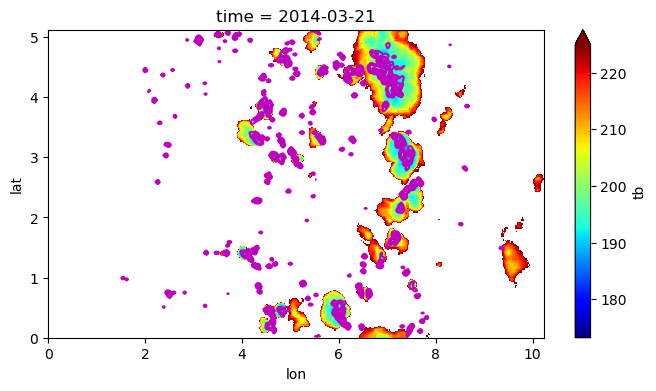

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
tmp = xr.open_dataset(out_dir / 'cm1out_rainrate_tb_20140321.000000.nc')
cp = tmp.tb.plot(ax=ax, vmax=225, cmap='jet')
cp.cmap.set_over('w')
tmp.rainrate.isel(time=0).plot.contour(ax=ax,levels=[1,5,10,20,30],colors=['m'])

In [8]:
cm1_dir = Path('/scratch/wmtsai/cm1_model/CM1_MCS/mcs_idealized_diurnal_LD/run/')
files = sorted(list(cm1_dir.glob('cm1out_00*.nc')))
tmp2 = xr.open_dataset(files[250])

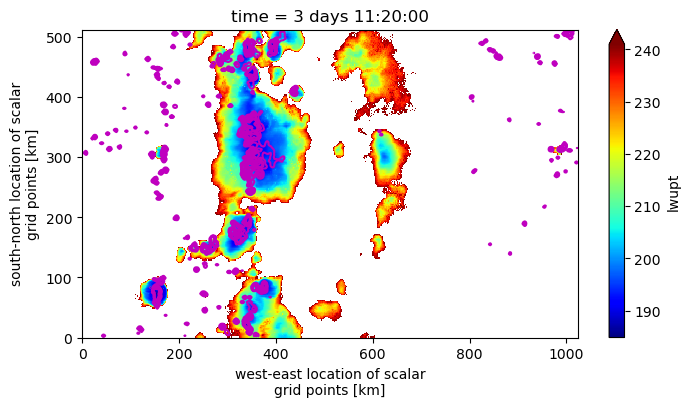

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
cp = olr_to_tb(tmp2.lwupt).plot(ax=ax,vmax=241,cmap='jet')
cp.cmap.set_over('w')
(3600*tmp2.prate.isel(time=0)).plot.contour(ax=ax,levels=[1,5,10,20,30],colors=['m'])

In [7]:
cm1_dir = Path('/scratch/wmtsai/cm1_model/CM1_MCS/mcs_idealized_diurnal_LD/run/')
files = sorted(list(cm1_dir.glob('cm1out_00*.nc')))
ds = xr.open_mfdataset(files)

In [8]:
prate_dmean = ds.prate.mean(('xh','yh')).compute()
sfx_dmean = (2.5e6*ds.qfx + ds.hfx).mean(('xh','yh')).compute()

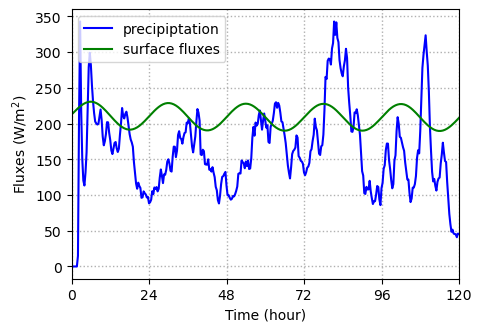

In [10]:
fig = plt.figure(figsize=(5,3.5))
times = np.linspace(0, 432000/3600, len(prate_dmean.time)) # 20-minute output frequency
plt.plot(times, 2.5e6*prate_dmean, color='b', label='precipiptation')
plt.plot(times, sfx_dmean, color='g', label='surface fluxes')
plt.xlabel('Time (hour)')
plt.ylabel('Fluxes (W/m$^{2}$)')
plt.legend(loc=2)
plt.grid(lw=1,ls=':')
plt.xticks(np.arange(0,144,24))
plt.xlim([0,120])
plt.show()

In [10]:
stats = xr.open_dataset('/scratch/wmtsai/PyFLEXTRKR/data/mcs_tbpf/cm1/stats/mcs_tracks_pf_20140319.0000_20140322.0000.nc',
                        mask_and_scale=False, decode_times=False)

In [11]:
tmp = stats.mcs_status
tmp = tmp.where(tmp >= 0, np.nan)

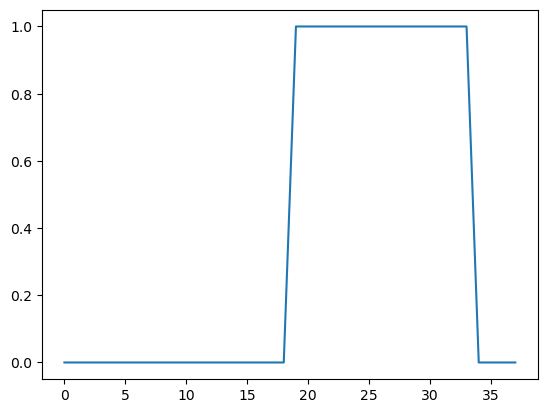

In [12]:
plt.plot(tmp[0,:])

In [13]:
# Create a flag for MCS status
dsout = stats
fillval = np.nan
mcs_tb_area_thresh = 8000
ccs_area = dsout['core_area'].data + dsout['cold_area'].data
mcs_status = np.full(ccs_area.shape, fillval, dtype=np.int16)
mcs_status[ccs_area > mcs_tb_area_thresh] = 1
mcs_status[(ccs_area <= mcs_tb_area_thresh) & (ccs_area > 0)] = 0

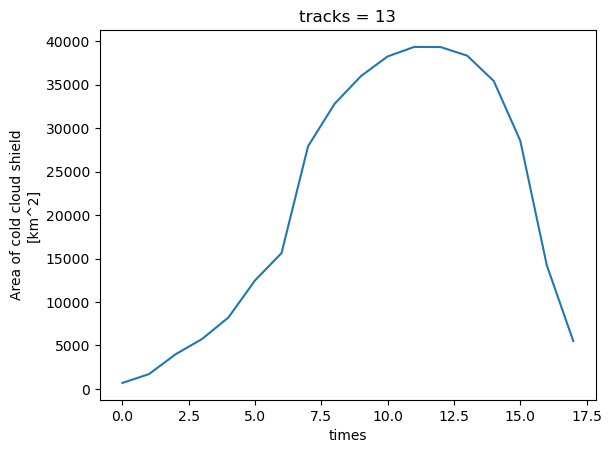

In [14]:
stats.isel(tracks=13).ccs_area.plot()

In [15]:
# Find track indices that are robust MCS
ntracks = stats.sizes['tracks']
ntimes = stats.sizes['times']
fillval = stats["mcs_status"].attrs["_FillValue"]
pf_mcsstatus = np.full((ntracks, ntimes), fillval, dtype=int)

TEMP_mcsstatus = np.copy(pf_mcsstatus).astype(float)
TEMP_mcsstatus[TEMP_mcsstatus == fillval] = np.nan
trackid_mcs = np.array(np.where(np.nansum(TEMP_mcsstatus, axis=1) > 0))[0, :]
nmcs = len(trackid_mcs)

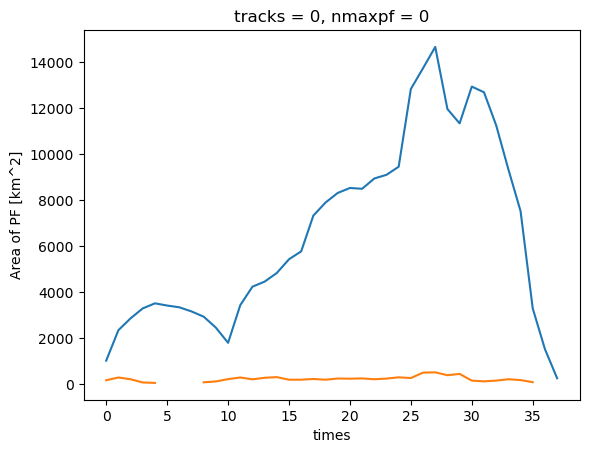

In [16]:
stats.ccs_area.isel(tracks=0).plot()
stats.pf_area.isel(nmaxpf=0,tracks=0).plot()

In [17]:
data = xr.open_dataset('/scratch/wmtsai/PyFLEXTRKR/data/mcs_tbpf/cm1/mcstracking_tb/20140319.0000_20140322.0000/mcstrack_20140321_212400.nc')

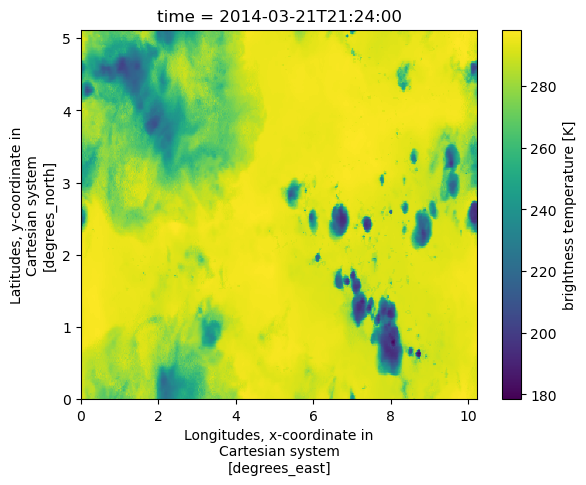

In [18]:
data.tb.plot()

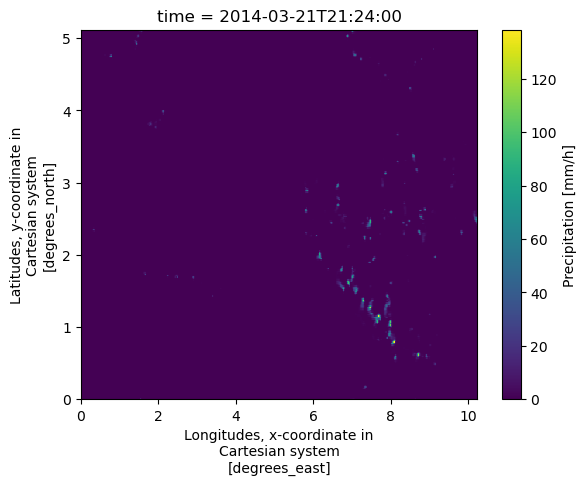

In [19]:
data.precipitation.plot()